In [36]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
gdrive/              model.png  sample_data/   vgg16-untrained-10epochs.jpg
hvc_annotations.csv  resized/   saved_models/


In [0]:
%tensorflow_version 1.x

import os
import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.applications import ResNet50
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator


In [0]:
# parameters
data_augmentation = True
pixel_level = False

In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [4]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [42]:
train_df.head()
len(train_df.columns)

28

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [9]:
# get number of output units from data
images, targets = next(iter(train_gen))
print(images.shape)
print(targets.keys())
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

(32, 224, 224, 3)
dict_keys(['gender_output', 'image_quality_output', 'age_output', 'weight_output', 'bag_output', 'pose_output', 'footwear_output', 'emotion_output'])


{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    # lr = 1e-3
    # if epoch > 180:
    #     lr *= 0.5e-3
    # elif epoch > 160:
    #     lr *= 1e-3
    # elif epoch > 120:
    #     lr *= 1e-2
    # elif epoch > 80:
    #     lr *= 1e-1
    lr = round(0.004 * 1/(1 + 0.319 * epoch), 10)
    print('Learning rate: ', lr)
    return lr

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [60]:
backbone = ResNet50(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="sigmoid", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

model.summary()
from keras.utils import plot_model

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
sgd = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=sgd,
    loss="binary_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [41]:
columns = ['gender_female', 'gender_male', 'imagequality_Average',
       'imagequality_Bad', 'imagequality_Good', 'age_15-25', 'age_25-35',
       'age_35-45', 'age_45-55', 'age_55+', 'weight_normal-healthy',
       'weight_over-weight', 'weight_slightly-overweight',
       'weight_underweight', 'carryingbag_Daily/Office/Work Bag',
       'carryingbag_Grocery/Home/Plastic Bag', 'carryingbag_None',
       'footwear_CantSee', 'footwear_Fancy', 'footwear_Normal',
       'emotion_Angry/Serious', 'emotion_Happy', 'emotion_Neutral',
       'emotion_Sad', 'bodypose_Back', 'bodypose_Front-Frontish',
       'bodypose_Side']
print(len(columns))

27


In [47]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = '%s_model.{epoch:03d}.h5' % 'resnet50'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [checkpoint, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit_generator(
              generator=train_gen,
              validation_data=valid_gen,
              batch_size=32,
              epochs=50,
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=pixel_level),
        # image data format, either "channels_first" or "channels_last"
        data_format=None)
    
    train_gen = datagen.flow_from_dataframe(
                          dataframe=train_df, 
                          batch_size=32,
                          x_col='image_path',
                          y_col=columns,
                          shuffle=True,
                          class_mode="other")


    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    #datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(
                        generator=train_gen,
                        validation_data=valid_gen,
                        use_multiprocessing=True,
                        epochs=50, 
                        verbose=1, 
                        workers=20,
                        callbacks=callbacks
                        )

Using real-time data augmentation.
Found 11537 validated image filenames.
Epoch 1/50
Learning rate:  0.004


ValueError: ignored

In [62]:
history = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=5, 
    epochs=10,
    verbose=1
)

Epoch 1/10
360/360 [==============================] - 121s 336ms/step - loss: 4.4959 - gender_output_loss: 0.7075 - image_quality_output_loss: 0.6106 - age_output_loss: 0.4911 - weight_output_loss: 0.4576 - bag_output_loss: 0.5813 - footwear_output_loss: 0.6378 - pose_output_loss: 0.5855 - emotion_output_loss: 0.4245 - gender_output_acc: 0.5449 - image_quality_output_acc: 0.6876 - age_output_acc: 0.7909 - weight_output_acc: 0.8089 - bag_output_acc: 0.6916 - footwear_output_acc: 0.6517 - pose_output_acc: 0.7304 - emotion_output_acc: 0.8480 - val_loss: 4.2486 - val_gender_output_loss: 0.6759 - val_image_quality_output_loss: 0.5735 - val_age_output_loss: 0.4684 - val_weight_output_loss: 0.4238 - val_bag_output_loss: 0.5547 - val_footwear_output_loss: 0.6015 - val_pose_output_loss: 0.5488 - val_emotion_output_loss: 0.4019 - val_gender_output_acc: 0.5610 - val_image_quality_output_acc: 0.7147 - val_age_output_acc: 0.8000 - val_weight_output_acc: 0.8241 - val_bag_output_acc: 0.7102 - val_foo

In [0]:
print(history.history.keys())

In [0]:
import matplotlib.pyplot as plt

def plot(history):
  # summarize history for accuracy
  
  for k in history.history.keys():
    plt.plot(history.history[k])
  plt.title('model')
  plt.xlabel('epoch')
  plt.show()

In [0]:
def plot_loss_and_acc(history):
  # plt.plot(history.history['loss'])
  # plt.plot(history.history['val_loss'])
  plt.plot(history.history['val_gender_output_acc'])
  plt.plot(history.history['val_image_quality_output_acc'])
  plt.plot(history.history['val_age_output_acc'])
  plt.plot(history.history['val_weight_output_acc'])
  plt.plot(history.history['val_bag_output_acc'])
  plt.plot(history.history['val_footwear_output_acc'])
  plt.plot(history.history['val_pose_output_acc'])
  plt.plot(history.history['val_emotion_output_acc'])
  
  plt.legend(['val_gender_output_acc', 
              'val_image_quality_output_acc', 
              'val_age_output_acc', 
              'val_weight_output_acc', 
              'val_bag_output_acc', 
              'val_footwear_output_acc', 
              'val_pose_output_acc', 
              'val_emotion_output_acc'], loc='upper left')
  plt.savefig('vgg16-untrained-10epochs.jpg')
  plt.show()
  files.download('vgg16-untrained-10epochs.jpg')

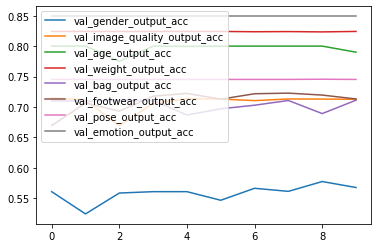

In [64]:
from google.colab import files
plot_loss_and_acc(history)

In [0]:
model